<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/notebooks/2021_0528edge_and_face_detection_algorithm_not_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DOG 等エッジ検出と顔検出の従来手法

In [ ]:
#グラフ描画時の日本語表示用モジュールのインストール
!pip install japanize_matplotlib

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import cv2 as cv  # opencv 画像処理モジュールの輸入

In [ ]:
#ファイルをアップロードします
from google.colab import files
#files?
files.upload()  # ご自身の PC からファイルをアップロードして下さい

In [ ]:
#アップロードしたファイルの表示
image_file = 'IMG_4056.jpg'     #自身のアップロードしたファイル名に書き換えてください

img_cv = cv.imread(image_file)
plt.figure(figsize = (6, 8))    #表示画像のサイズ (縦, 横) 単位はインチ。だけど画面の解像度により変化するので目安程度
plt.axis('off')                               #画像描画時の軸表示をオフ
img = cv.cvtColor(img_cv, cv.COLOR_BGR2RGB)   #OpenCV は RGB ではなく BGR なので変換
plt.imshow(img)                               #画像表示

画像のサイズ: (960, 1280)
画像の画素の値
[[0.03 0.05 0.05 ... 0.63 0.63 0.63]
 [0.04 0.05 0.05 ... 0.63 0.64 0.64]
 [0.05 0.05 0.05 ... 0.63 0.64 0.64]
 ...
 [0.41 0.41 0.42 ... 0.65 0.7  0.75]
 [0.41 0.41 0.41 ... 0.65 0.72 0.77]
 [0.4  0.41 0.4  ... 0.69 0.73 0.8 ]]
一次元にしてみます [0.03 0.05 0.05 ... 0.69 0.73 0.8 ]


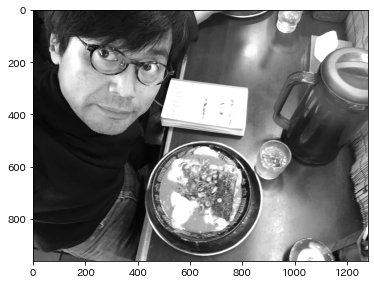

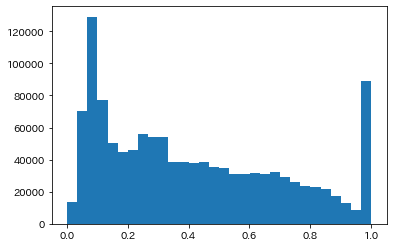

In [3]:
from skimage.color import rgb2gray            #カラー画像をグレー濃淡画像に変換するため

img_gray = rgb2gray(img)
print('画像のサイズ:', img_gray.shape)
print('画像の画素の値')
print(np.round(img_gray, 2))

# flattened pixel feature vector
print('一次元にしてみます', (np.round(img_gray.flatten(), 2)))

plt.figure(figsize = (6, 8))
plt.imshow(img_gray, cmap="gray"); plt.show()
c_freq, c_bins, c_patches = plt.hist(img_gray.flatten(), bins=30) #ヒストグラムの描画

# 今回は授業で説明した HAAR 特徴を用いた顔領域切り出しを行います

- HAAR 特徴とは，アルフレッド ハール (Alfred Haar) の提案したカーネルです。
- ビオラ・ジョーンズアルゴリズムは，HAAR 特徴と ブースティングを用いて，実時間で（つまり時間遅れなく，リアルタイムで）顔検出を行うことができます。

In [ ]:
#顔領域検出用データを外部から入手。
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalcatface.xml    

In [4]:
# opencv の顔認識モジュールをロードします
opencv_base = '.'
face_cascade = cv.CascadeClassifier(os.path.join(opencv_base,'haarcascade_frontalcatface.xml'))
#face_cascade = cv.CascadeClassifier(os.path.join(opencv_base,'haarcascade_frontalface_alt2.xml'))
#face_cascade = cv.CascadeClassifier(os.path.join(opencv_base,'haarcascade_fullbody.xml'))

In [ ]:
files.upload()  #必要に応じて顔を含む画像を PC からファイルをアップロードして下さい

In [5]:
face_image_filename = 'IMG_4056.jpg'  # アップロードした顔画像ファイル名に書き換えてください
original_image = cv.imread(face_image_filename)

#ビオラ＝ジョーンズアルゴリズムを使うために濃淡画像に変換
grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)

#顔領域の検出
detected_faces = face_cascade.detectMultiScale(grayscale_image)

In [6]:
#検出した顔領域を元画像に書き込む
for (column, row, width, height) in detected_faces:
    cv.rectangle(
        original_image,
        (column, row),
        (column + width, row + height),
        (255, 0, 0),
        2
    )

In [ ]:
#認識結果の表示
plt.figure(figsize=(12,8))
plt.axis('off')
plt.imshow(original_image, cmap='gray')

# 畳み込み積分，あるいは カーネル の実習

In [ ]:
# カーネルを適切に設定してください
W1 = np.array([[0,1,0],
               [0,1,0],
               [0,1,0]])
W2 = np.array([[0,0,0],
               [1,1,1],
               [0,0,0]])
W3 = np.array([[1,0,0],
               [0,1,0],
               [0,0,1]])
W4 = np.array([[0,0,1],
               [0,1,0],
               [1,0,0]])

plt.figure(figsize=(8,4))
plt.subplot(1,4,1); plt.imshow(W1, cmap='gray')
plt.subplot(1,4,2); plt.imshow(W2, cmap='gray')
plt.subplot(1,4,3); plt.imshow(W3, cmap='gray')
plt.subplot(1,4,4); plt.imshow(W4, cmap='gray')
plt.suptitle("カーネル", fontsize=12)
plt.show()

In [ ]:
# シンプルな畳み込み層を定義
class Conv:
    # シンプルな例を考えるため、カーネル幅 Wは 3x3で固定
    # strides や padding は考えません
    def __init__(self, W):
        self.W = W
    def f_prop(self, X):
        out = np.zeros((X.shape[0]-2, X.shape[1]-2))
        for i in range(out.shape[0]):
            for j in range(out.shape[1]):
                x = X[i:i+3, j:j+3]
                # 要素ごとの積の合計をとっています
                out[i,j] = np.dot(self.W.flatten(), x.flatten())
        return out


In [ ]:
from skimage.color import rgb2gray

image_filename = 'IMG_4056.jpg'      #ファイル名はアップロードしたファイル名に合わせて変更します
img = plt.imread(image_file)
print(img.shape)  # 画像のサイズを表示します

img = rgb2gray(img) # 濃淡画像(グレースケール)に変換
plt.axis('off')
plt.imshow(img, cmap='gray')

In [ ]:
#type(img)
# 畳み込み
X = np.copy(img)
conv1 = Conv(W1); C1 = conv1.f_prop(X)
conv2 = Conv(W2); C2 = conv2.f_prop(X)
conv3 = Conv(W3); C3 = conv3.f_prop(X)
conv4 = Conv(W4); C4 = conv4.f_prop(X)


In [ ]:
plt.subplot(1,4,1); plt.imshow(C1,cmap='gray')
plt.subplot(1,4,2); plt.imshow(C2,cmap='gray')
plt.subplot(1,4,3); plt.imshow(C3,cmap='gray')
plt.subplot(1,4,4); plt.imshow(C4,cmap='gray')
plt.suptitle("畳み込み演算の結果", fontsize=12)
plt.show()

# DOG 演算の実習

- 2 つのガウス分布（正規分布）の差分を使った，エッジ検出
- 画像処理の基本となる考え方

In [9]:
#DoG 関数の定義
def DoG(img, ker1=3, ker2=5):
    blur2 = cv.GaussianBlur(img, (ker2, ker2), 0)
    blur1 = cv.GaussianBlur(img, (ker1, ker1), 0)

    return blur2 - blur1


In [ ]:
dog_img = DoG(img)
plt.imshow(dog_img); plt.show()

dog_img = DoG(img, ker1=3, ker2=9)
plt.imshow(dog_img); plt.show()

# エッジ検出の実習

In [ ]:
# Canny アルゴリズムによるエッジ（端点）検出の実演
from skimage.feature import canny

img_edges = canny(img_gray, sigma=3)

plt.figure(figsize = (6, 8))
plt.axis('off')
plt.imshow(img_edges, cmap='binary')


In [ ]:
#HOG の実演
from skimage.feature import hog
from skimage import exposure

# 下の orientation の値は 0 から 9 までです。変化させて，結果を観察してください
fd_img, img_hog = hog(img_gray, orientations=8, pixels_per_cell=(8, 8), 
                      cells_per_block=(3, 3), visualize=True)

# rescaling intensity to get better plots
img_hogs = exposure.rescale_intensity(img_hog, in_range=(0, 0.04))

plt.figure(figsize = (6, 8))
plt.axis('off')
plt.imshow(img_hogs, cmap='binary')
